In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
!pip install folium

In [14]:
!pip install ace_tools

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3. 군집 분석 (Clustering) - K-Means, DBSCAN, 계층적 군집 분석

In [4]:
import pandas as pd
import numpy as np
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [7]:
# 📌 1. 데이터 로드
file_path = "/content/drive/MyDrive/Colab Notebooks/(발표)_최종승객수예측_clustering.xlsx"
df_original = pd.read_excel(file_path)

# 📌 2. 필요한 컬럼 선택 (승차 위도, 경도 / 하차 위도, 경도 / 2025년 1월 예측 승객수)
df = df_original[['승차_위도', '승차_경도', '하차_위도', '하차_경도']].dropna()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50883 (\N{HANGUL SYLLABLE US}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

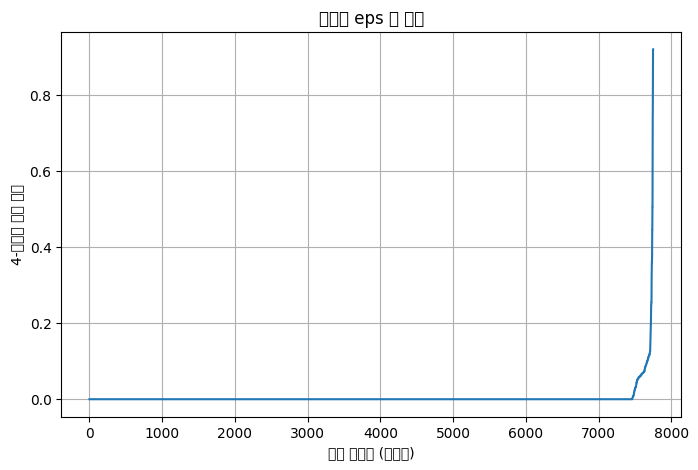

In [43]:
# 📌 3. 클러스터링을 위한 데이터 스케일링
X = df[['하차_위도', '하차_경도']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📌 4. 최적의 eps 찾기 (k-최근접 이웃 거리 그래프)
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# 📌 5. 거리 정렬 후 시각화
distances = np.sort(distances[:, 4])  # 4번째 최근접 이웃 거리
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("샘플 인덱스 (정렬됨)")
plt.ylabel("4-최근접 이웃 거리")
plt.title("최적의 eps 값 결정")
plt.grid()
plt.show()

In [69]:
# 📌 1. 최적의 eps와 min_samples 찾기 (노이즈 비율 10% 이하 고려 & 후보 3개 저장)
best_candidates = []  # 최적 후보 리스트

for eps in np.arange(0.05, 0.55, 0.05):  # eps 값을 0.25 ~ 0.45 범위에서 증가
    for min_samples in range(10, 70, 10):  # min_samples 값을 10~60 범위에서 증가
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)

        # 📌 성능 지표 계산
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        num_noise = list(cluster_labels).count(-1)
        noise_ratio = num_noise / len(cluster_labels)

        # 📌 클러스터 개수가 5~8개 사이이고, 노이즈 비율이 10% 이하인 경우 최적 후보로 저장
        if 5 <= num_clusters <= 10 and noise_ratio <= 0.1:
            best_candidates.append((eps, min_samples, num_clusters, noise_ratio))
            print(f"✅ 후보: eps={eps:.2f}, min_samples={min_samples}, 클러스터 개수={num_clusters}, 노이즈 비율={noise_ratio:.2%}")

        # 상위 3개 후보만 저장
        if len(best_candidates) >= 5:
            break
    if len(best_candidates) >= 5:
        break

# 📌 2. 최적 후보 중 첫 번째 값으로 DBSCAN 수행
if best_candidates:
    best_eps, best_min_samples, best_cluster_count, best_noise_ratio = best_candidates[0]
    print(f"\n🎯 최적 파라미터 적용: eps={best_eps}, min_samples={best_min_samples}")

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    df = df.reset_index(drop=True)  # 인덱스 리셋하여 데이터 정렬
    df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)
else:
    print("❌ 5~8개 클러스터 및 노이즈 비율 10% 이하 조건을 만족하는 설정을 찾지 못했습니다.")
    df['dbscan_cluster'] = -1  # 기본적으로 -1로 설정

# 📌 3. 최적 후보 3개 출력
best_candidates_df = pd.DataFrame(best_candidates, columns=['eps', 'min_samples', 'num_clusters', 'noise_ratio'])
print("\n🔹 최적 DBSCAN 후보 5개:")
print(best_candidates_df)

# 📌 4. 클러스터링 결과를 포함한 데이터 반환
df



✅ 후보: eps=0.20, min_samples=50, 클러스터 개수=9, 노이즈 비율=6.01%
✅ 후보: eps=0.20, min_samples=60, 클러스터 개수=8, 노이즈 비율=7.82%
✅ 후보: eps=0.25, min_samples=10, 클러스터 개수=10, 노이즈 비율=0.75%
✅ 후보: eps=0.25, min_samples=20, 클러스터 개수=7, 노이즈 비율=1.38%
✅ 후보: eps=0.25, min_samples=30, 클러스터 개수=8, 노이즈 비율=1.56%

🎯 최적 파라미터 적용: eps=0.2, min_samples=50

🔹 최적 DBSCAN 후보 5개:
    eps  min_samples  num_clusters  noise_ratio
0  0.20           50             9     0.060137
1  0.20           60             8     0.078204
2  0.25           10            10     0.007485
3  0.25           20             7     0.013808
4  0.25           30             8     0.015615


,승차_위도,승차_경도,하차_위도,하차_경도,dbscan_cluster,color,dbscan_cluster_Y
0,37.481581,126.882581,37.475276,126.632802,0,blue,0
1,37.481581,126.882581,37.489445,126.724506,0,blue,0
2,37.481581,126.882581,37.056496,127.052819,-1,blue,0
3,37.481581,126.882581,37.266348,126.999561,1,blue,0
4,37.481581,126.882581,37.168953,127.063197,-1,blue,0
...,...,...,...,...,...,...,...
7744,37.464992,126.679098,37.476050,126.867911,0,blue,42
7745,37.464992,126.679098,37.514229,127.031656,0,blue,42
7746,37.464992,126.679098,37.561916,126.802152,0,blue,42
7747,37.464992,126.679098,37.566778,126.827310,0,blue,42


In [50]:
# 📌 3. 클러스터링을 위한 데이터 스케일링
Y = df[['승차_위도', '승차_경도']].values
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

In [68]:
# 📌 1. 최적의 eps와 min_samples 찾기 (노이즈 비율 10% 이하 고려 & 후보 3개 저장)
best_candidates = []  # 최적 후보 리스트

for eps in np.arange(0.05, 0.55, 0.05):  # eps 값을 0.25 ~ 0.45 범위에서 증가
    for min_samples in range(10, 70, 10):  # min_samples 값을 10~60 범위에서 증가
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels_Y = dbscan.fit_predict(Y_scaled)

        # 📌 성능 지표 계산
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        num_noise = list(cluster_labels).count(-1)
        noise_ratio = num_noise / len(cluster_labels)

        # 📌 클러스터 개수가 5~8개 사이이고, 노이즈 비율이 10% 이하인 경우 최적 후보로 저장
        if 5 <= num_clusters <= 10 and noise_ratio <= 0.1:
            best_candidates.append((eps, min_samples, num_clusters, noise_ratio))
            print(f"✅ 후보: eps={eps:.2f}, min_samples={min_samples}, 클러스터 개수={num_clusters}, 노이즈 비율={noise_ratio:.2%}")

        # 상위 3개 후보만 저장
        if len(best_candidates) >= 5:
            break
    if len(best_candidates) >= 5:
        break

# 📌 2. 최적 후보 중 첫 번째 값으로 DBSCAN 수행
if best_candidates:
    best_eps, best_min_samples, best_cluster_count, best_noise_ratio = best_candidates[0]
    print(f"\n🎯 최적 파라미터 적용: eps={best_eps}, min_samples={best_min_samples}")

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    df = df.reset_index(drop=True)  # 인덱스 리셋하여 데이터 정렬
    df['dbscan_cluster_Y'] = dbscan.fit_predict(Y_scaled)
else:
    print("❌ 5~8개 클러스터 및 노이즈 비율 10% 이하 조건을 만족하는 설정을 찾지 못했습니다.")
    df['dbscan_cluster'] = -1  # 기본적으로 -1로 설정

# 📌 3. 최적 후보 3개 출력
best_candidates_df = pd.DataFrame(best_candidates, columns=['eps', 'min_samples', 'num_clusters', 'noise_ratio'])
print("\n🔹 최적 DBSCAN 후보 5개:")
print(best_candidates_df)

# 📌 4. 클러스터링 결과를 포함한 데이터 반환
df

✅ 후보: eps=0.05, min_samples=10, 클러스터 개수=9, 노이즈 비율=6.01%
✅ 후보: eps=0.05, min_samples=20, 클러스터 개수=9, 노이즈 비율=6.01%
✅ 후보: eps=0.05, min_samples=30, 클러스터 개수=9, 노이즈 비율=6.01%
✅ 후보: eps=0.05, min_samples=40, 클러스터 개수=9, 노이즈 비율=6.01%
✅ 후보: eps=0.05, min_samples=50, 클러스터 개수=9, 노이즈 비율=6.01%

🎯 최적 파라미터 적용: eps=0.05, min_samples=10

🔹 최적 DBSCAN 후보 5개:
    eps  min_samples  num_clusters  noise_ratio
0  0.05           10             9     0.060137
1  0.05           20             9     0.060137
2  0.05           30             9     0.060137
3  0.05           40             9     0.060137
4  0.05           50             9     0.060137


,승차_위도,승차_경도,하차_위도,하차_경도,dbscan_cluster,color,dbscan_cluster_Y
0,37.481581,126.882581,37.475276,126.632802,0,blue,0
1,37.481581,126.882581,37.489445,126.724506,0,blue,0
2,37.481581,126.882581,37.056496,127.052819,-1,blue,0
3,37.481581,126.882581,37.266348,126.999561,1,blue,0
4,37.481581,126.882581,37.168953,127.063197,-1,blue,0
...,...,...,...,...,...,...,...
7744,37.464992,126.679098,37.476050,126.867911,0,blue,42
7745,37.464992,126.679098,37.514229,127.031656,0,blue,42
7746,37.464992,126.679098,37.561916,126.802152,0,blue,42
7747,37.464992,126.679098,37.566778,126.827310,0,blue,42


In [64]:
# 📌 6. 적절한 eps 설정 후 DBSCAN 수행
eps_value = 0.2  # 위 그래프를 기반으로 설정 (조정 가능)
dbscan = DBSCAN(eps=eps_value, min_samples=50)
cluster_labels = dbscan.fit_predict(X_scaled)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

In [65]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, cluster_labels)
sil_score

0.14873319753514652

In [66]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
ch_score

693.9343126083155

In [67]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(X_scaled, cluster_labels)
db_score

2.434581442646005

In [52]:
# 📌 6. 적절한 eps 설정 후 DBSCAN 수행
eps_value = 0.2  # 위 그래프를 기반으로 설정 (조정 가능)
dbscan = DBSCAN(eps=eps_value, min_samples=50)
df['dbscan_cluster_Y'] = dbscan.fit_predict(Y_scaled)

In [56]:
colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
df['color'] = df['dbscan_cluster'].apply(lambda x: 'black' if x == -1 else colors[x % len(colors)])

# 📌 4. 지도 초기화 (하차 지점)
center_lat_dropoff, center_lon_dropoff = df['하차_위도'].mean(), df['하차_경도'].mean()
m_dropoff = folium.Map(location=[center_lat_dropoff, center_lon_dropoff], zoom_start=11)

# 📌 6. 하차 지점 시각화
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['하차_위도'], row['하차_경도']],
        radius=2,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6,
        popup=f"하차 - Cluster {row['dbscan_cluster']}"
    ).add_to(m_dropoff)

# 📌 7. 두 개의 지도 출력
m_dropoff

Output hidden; open in https://colab.research.google.com to view.

In [57]:
colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink']
df['color'] = df['dbscan_cluster_Y'].apply(lambda x: 'black' if x == -1 else colors[x % len(colors)])

# 📌 4. 지도 초기화 (하차 지점)
center_lat_pickup, center_lon_pickup = df['승차_위도'].mean(), df['승차_경도'].mean()
m_pickup = folium.Map(location=[center_lat_pickup, center_lon_pickup], zoom_start=11)

# 📌 6. 하차 지점 시각화
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['승차_위도'], row['승차_경도']],
        radius=2,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.6,
        popup=f"하차 - Cluster {row['dbscan_cluster_Y']}"
    ).add_to(m_pickup)

# 📌 7. 두 개의 지도 출력
m_pickup

Output hidden; open in https://colab.research.google.com to view.

In [55]:
# 📌 5. 클러스터링 결과를 원본 데이터에 병합
df_original = df_original.merge(df[['승차_위도', '승차_경도', '하차_위도', '하차_경도', 'dbscan_cluster']],
                                on=['승차_위도', '승차_경도', '하차_위도', '하차_경도'], how='left')

# 📌 6. 결과 엑셀 저장
output_file_path = "DBSCAN_클러스터링_결과_포함.xlsx"
df_original.to_excel(output_file_path, index=False)
